# Audio Feature Analyses SIM 1 - Detecting Kermit and Waldorf & Statler

This notebook contains the audio feature analysis for the Similarity Modeling 1 project. The objective is to detect the presence of Kermit, Waldorf, and Statler in a scene using audio features. These features are extracted using the methods outlined below. For the classification task, we employ K-Nearest Neighbors (KNN) and Logistic Regression algorithms, combined with a nested cross-validation approach. Additionally, we implement the XGBoost model used in the SIM2 Project to analyze its performance across all three subtasks: visual, audio, and visual + audio.

In [1]:
import librosa
import numpy as np
import pandas as pd

from scripts.load_data import check_and_load
from scripts.extract_audio_features import extract_zcr, extract_loudness, extract_rhythm, extract_mfcc
from scripts.nested_cv import partition_feature_df#, nested_cross_validation, evaluate_model, ncv_xgb_gpu


## Data Loading

In [2]:
# # Define paths
# data_path = "../ground_truth_data/trimmed_videos"
# frames_output_dir = "../ground_truth_data/trimmed_videos/frames"
# audio_output_dir = "../ground_truth_data/trimmed_videos/audio"
# annotations_path = "../ground_truth_data/trimmed_videos"

data_path = "../ground_truth_data"
frames_output_dir = "../ground_truth_data/frames"
audio_output_dir = "../ground_truth_data/audio"
annotations_path = "../ground_truth_data"

muppet_files = {
    "Muppets-02-01-01.avi": "GroundTruth_Muppets-02-01-01.csv",
    "Muppets-02-04-04.avi": "GroundTruth_Muppets-02-04-04.csv",
    "Muppets-03-04-03.avi": "GroundTruth_Muppets-03-04-03.csv",
}

In [3]:
annotations, audio_data, frames = check_and_load(data_path, frames_output_dir, audio_output_dir, annotations_path, muppet_files)

Frames and audio are already extracted.
Loading audio segments...
Loaded 3 audio files.
Loaded audio segments for 3 videos.
Loaded frames for 3 videos.
Number of videos with frames: 3
Video 0 has 38681 frames.
Video 1 has 38706 frames.
Video 2 has 38498 frames.


## Feature Engineering

This chapter delves into the extraction of meaningful audio features to support the classification task. The objective is to transform raw audio data into a structured format that emphasizes patterns and characteristics essential for detecting the presence of Kermit, Waldorf, and Statler.

For initial experimentation, we utilized methods introduced in Similarity Modeling 1, including Zero-Crossing Rate (ZCR), loudness, and rhythm detection. However, these features alone yielded poor classification results. To address this issue, we incorporated Mel-Frequency Cepstral Coefficients (MFCCs), as introduced in Similarity Modeling 2. This decision was informed by experiments conducted during the audio analysis phase of the Similarity Modeling 2 project and was aimed at improving classification performance to achieve viable results.

### Feature Extraction

The feature extraction process is implemented in the `extract_audio_features.py` file, leveraging the `librosa` library to transform raw audio data into structured features suitable for classification. This approach involves three key steps: padding, normalization, and feature computation.

#### 1. Padding
The extracted audio signals are slightly shorter than the original video, making it essential to align their duration to ensure that the audio frames correspond to the frames in the annotations (`ground_truth`). Thus, padding—specifically zero-padding—is applied to extend the shorter audio signals to the required length by filling gaps at the end of the audio signals without altering their original structure.

#### 2. Normalization
After padding, audio signals are normalized to a common scale. This step adjusts the amplitude values to a standardized range, enhancing the comparability of features across samples and mitigating the effects of volume differences.

#### 3. Feature Computation
Finally, the padded and normalized audio signals are processed to extract the following features:

- **Zero-Crossing Rate (ZCR)**: Measures the rate at which the audio signal crosses the zero amplitude axis, capturing information about its frequency content. This could be useful for identifying distinct pitch or tonal qualities in their voices, such as Kermit's high-pitched voice.
- **Loudness (Root Mean Square Energy)**: Computes the signal's overall energy, providing insights into its intensity. This could help differentiate characters based on the volume or energy of their speech or sound.
- **Rhythm Detection**: Employs autocorrelation to identify repeating patterns within frames, capturing rhythmic structures in the audio.
- **Mel-Frequency Cepstral Coefficients (MFCCs)**: Combines short-time Fourier transforms, Mel transformations, and discrete cosine transforms to capture spectral properties of the signal, particularly suited for identifying speech and tonal patterns.


In [4]:
# Calculate ZCR features
zcr_features = extract_zcr(audio_data)

# Extract loudness features
loudness_features = extract_loudness(audio_data)

# Extract rhythm features
rhythm_features = extract_rhythm(audio_data)

# Extract mfcc features
mfcc_features = extract_mfcc(audio_data, n_mfcc=20)

In [5]:
# Initialize the final list to hold feature rows
extracted_features_df = []

# Loop through the data for each video
for video_idx, (audio_entry, zcr, loudness, rhythm, mfcc) in enumerate(
        zip(audio_data, zcr_features, loudness_features, rhythm_features, mfcc_features)):
    
    if all(feature is not None for feature in [zcr, loudness, rhythm, mfcc]):
        # Determine the minimum number of frames across all features for alignment
        num_frames = min(len(zcr), len(loudness), len(rhythm), mfcc.shape[1] - 2)  # -2 accounts for edge frames in MFCC

        for frame_idx in range(num_frames):
            # Extract ZCR, loudness, rhythm, and MFCC features for the current frame
            feature_row = {
                "video_idx": video_idx,
                "frame_idx": frame_idx,
                "zcr": zcr[frame_idx],
                "loudness_rms": loudness[frame_idx],
                "rhythm": rhythm[frame_idx],
            }

            # Add MFCC features
            mfcc_values = {f"mfcc_{i+1}": mfcc[i, frame_idx] for i in range(mfcc.shape[0])}
            feature_row.update(mfcc_values)

            # Append the row to the list
            extracted_features_df.append(feature_row)

# Convert the list of features into a DataFrame
extracted_features_df = pd.DataFrame(extracted_features_df)

# Display the shape of the combined DataFrame
print(extracted_features_df.shape)


(115885, 25)


In [6]:
for i in extracted_features_df["video_idx"].unique():
    print(f"Video {i}: {extracted_features_df[extracted_features_df['video_idx'] == i].shape}")

# Video 0 has 38681 frames.
# Video 1 has 38706 frames.
# Video 2 has 38498 frames.

Video 0: (38681, 25)
Video 1: (38706, 25)
Video 2: (38498, 25)


## Model Prep

A relevant remark is that there are only audio annotations for Statler and Waldorf, but none for Kermit, so we decide to use the visual annotations. 

Load Ground Truth

In [7]:
# Create a mapping from filenames to video indices
video_idx_map = {filename: idx for idx, filename in enumerate(muppet_files.keys())}

# Prepare ground truth data with corrected video_idx
ground_truth_data = []
for video_filename, annotation_df in annotations.items():
    video_idx = video_idx_map[video_filename]  # Map video filename to its index
    for _, row in annotation_df.iterrows():
        ground_truth_data.append({
            'video_idx': video_idx,  # Use mapped video index
            'frame_idx': row['Frame_number'],  # Assuming Frame_number exists
            'Kermit': row['Kermit'],  # Assuming Kermit is a column in the annotation
            'Audio_StatlerWaldorf': row['Audio_StatlerWaldorf']  # Assuming this column exists
        })

# Create a DataFrame for ground truth
ground_truth_df = pd.DataFrame(ground_truth_data)

In [8]:
print(ground_truth_df.shape)
print(extracted_features_df.shape)

(115885, 4)
(115885, 25)


Merge with features dataframe

In [9]:
# Merge features with ground truth
feature_df = pd.merge(extracted_features_df, ground_truth_df, on=['video_idx', 'frame_idx'], how='left')
feature_df.shape

(115885, 27)

Partition the dataframe into folds (this will be discussed in the Train-Test-Split chapter).

In [10]:
# split_points = {
#     0: 19716,  # Video 0
#     1: 19719,  # Video 1
#     2: 19432, # Video 2 
# }

# Assuming feature_df is the dataframe containing video_idx and frame_idx columns

grp_by = ['Kermit', 'Audio_StatlerWaldorf']
feature_df, split_overview = partition_feature_df(feature_df, grp_by = grp_by)

In [11]:
feature_df.head()

,video_idx,frame_idx,zcr,loudness_rms,rhythm,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,Kermit,Audio_StatlerWaldorf,fold
0,0,0,0.0,0.0,0.0,-548.863586,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0-A
1,0,1,0.0,0.0,0.0,-548.863586,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0-A
2,0,2,0.0,0.0,0.0,-548.863586,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0-A
3,0,3,0.0,0.0,0.0,-548.863586,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0-A
4,0,4,0.0,0.0,0.0,-548.863586,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0-A


In [12]:
# Display the results
print(split_overview)

feature_df['fold'].unique()

   video_idx fold  Kermit  Audio_StatlerWaldorf
0          0  0-A    2916                  1015
1          0  0-B    2533                   399
2          1  1-A    3925                   542
3          1  1-B    8327                   282
4          2  2-A    5231                   171
5          2  2-B   10277                   308


array(['0-A', '0-B', '1-A', '1-B', '2-A', '2-B'], dtype=object)

In [13]:
extracted_features_df.columns

Index(['video_idx', 'frame_idx', 'zcr', 'loudness_rms', 'rhythm', 'mfcc_1',
       'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
       'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14',
       'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20'],
      dtype='object')

In [14]:
# Check for invalid values
#train_cols = ['loudness_rms', 'rhythm', 'zcr', 'stft_mean', 'spectral_centroid', 'spectral_bandwidth']
train_cols = ['loudness_rms', 'rhythm', 'zcr',
              'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
              'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 
              'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 
              'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 
              'mfcc_17','mfcc_18', 'mfcc_19', 'mfcc_20']


print("NaN in features:", feature_df[train_cols].isnull().sum())
print()
print("Infinite values in features:", np.isinf(feature_df[train_cols]).sum())


NaN in features: loudness_rms    0
rhythm          0
zcr             0
mfcc_1          0
mfcc_2          0
mfcc_3          0
mfcc_4          0
mfcc_5          0
mfcc_6          0
mfcc_7          0
mfcc_8          0
mfcc_9          0
mfcc_10         0
mfcc_11         0
mfcc_12         0
mfcc_13         0
mfcc_14         0
mfcc_15         0
mfcc_16         0
mfcc_17         0
mfcc_18         0
mfcc_19         0
mfcc_20         0
dtype: int64

Infinite values in features: loudness_rms    0
rhythm          0
zcr             0
mfcc_1          0
mfcc_2          0
mfcc_3          0
mfcc_4          0
mfcc_5          0
mfcc_6          0
mfcc_7          0
mfcc_8          0
mfcc_9          0
mfcc_10         0
mfcc_11         0
mfcc_12         0
mfcc_13         0
mfcc_14         0
mfcc_15         0
mfcc_16         0
mfcc_17         0
mfcc_18         0
mfcc_19         0
mfcc_20         0
dtype: int64


In [15]:
# # Add the target variable to feature_df
# feature_df['target'] = create_target_variable(feature_df)

# print("Unique target values:", feature_df['target'].unique())
# Note Statler/Wald and Kermit have no simultanous 1s thus [0,1,2]

# Audio Classification

For the initial analysis, we employed a K-Nearest Neighbors (K-NN) classifier, an example of a "hedger" algorithm, and a Logistic Regression classifier, which acts as a "separator." Due to limited computational resources, the parameter grids for these models were kept small. Finally, we implement an XGBoost Gradient Boosting Algorithm, which is used to compare the XGBoost Performance over all the files.

In [16]:
import numpy as np
import pandas as pd

from scripts.nested_cv import evaluate_model, nested_cross_validation, ncv_xgb_gpu
import psutil
import os

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

physical_cores = psutil.cpu_count(logical=False)
print(f"Number of physical cores: {physical_cores}")

os.environ["LOKY_MAX_CPU_COUNT"] = "12"

Number of physical cores: 12


In [17]:
feature_df = pd.read_csv('../model_vars/sim1_audio/feature_df.csv')


train_cols = ['loudness_rms', 'rhythm', 'zcr',
              'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
              'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 
              'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 
              'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 
              'mfcc_17','mfcc_18', 'mfcc_19', 'mfcc_20']

## Train-Test-Split Approach

In this analysis, we employ a nested cross-validation approach for our classification models. The nested cross-validation provides robust model evaluation by incorporating two levels of data splitting: an outer loop for testing model generalization and an inner loop for hyperparameter tuning. The outer loop ensures that the performance metrics reflect how well the model generalizes to entirely unseen data, while the inner loop systematically optimizes the model's parameters using the training data.

A traditional random train-test split could lead to data leakage if frames from the same video appear in both the training and testing sets. This overlap could inflate performance metrics by allowing the model to learn video-specific features rather than generalizable patterns. The nested cross-validation mitigates this risk by ensuring that the outer splits isolate data from different videos, providing a more realistic estimate of the model's ability to generalize across unseen scenarios. 

For the creation of the folds, each episode is split at its midway point, specifically at the transition where a segment ends and the screen briefly fades to black before the next segment begins. This results in two distinct folds per episode, ensuring that each fold captures a separate and coherent part of the episode.

## KNN

### Kermit

In [18]:
from sklearn.neighbors import KNeighborsClassifier 

# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    #'metric': ['euclidean', 'manhattan'] 
}

#train_cols = ['loudness_rms', 'rhythm', 'zcr']
target_col = 'Kermit'
results_kermit, summary_kermit, best_model_kermit = nested_cross_validation(
    feature_df, 
    train_cols, 
    target_col, 
    KNeighborsClassifier, 
    param_grid, 
    num_cores = 10,
    scoring="recall_weighted")

Metrics for Fold 0-A: {'outer_fold': '0-A', 'accuracy': 0.7264150943396226, 'precision': np.float64(0.2486815415821501), 'recall': np.float64(0.4204389574759945), 'f1': np.float64(0.312515931684935), 'roc_auc': np.float64(0.635370380576785)}
Metrics for Fold 0-B: {'outer_fold': '0-B', 'accuracy': 0.7463749011336673, 'precision': np.float64(0.21111393047449886), 'recall': np.float64(0.32846427161468617), 'f1': np.float64(0.2570281124497992), 'roc_auc': np.float64(0.6098091607528434)}
Metrics for Fold 1-A: {'outer_fold': '1-A', 'accuracy': 0.7218418783913991, 'precision': np.float64(0.33211364614722344), 'recall': np.float64(0.39312101910828023), 'f1': np.float64(0.36005133590012833), 'roc_auc': np.float64(0.64131034199071)}
Metrics for Fold 1-B: {'outer_fold': '1-B', 'accuracy': 0.6034655290461896, 'precision': np.float64(0.5947293447293447), 'recall': np.float64(0.3008286297586166), 'f1': np.float64(0.39955339341255286), 'roc_auc': np.float64(0.6040441241910456)}
Metrics for Fold 2-A: 

In [19]:
print(results_kermit)

print(summary_kermit)

  outer_fold  accuracy  precision    recall        f1   roc_auc
0        0-A  0.726415   0.248682  0.420439  0.312516  0.635370
1        0-B  0.746375   0.211114  0.328464  0.257028  0.609809
2        1-A  0.721842   0.332114  0.393121  0.360051  0.641310
3        1-B  0.603466   0.594729  0.300829  0.399553  0.604044
4        2-A  0.645173   0.353315  0.383101  0.367605  0.592974
5        2-B  0.487097   0.561270  0.221952  0.318109  0.511557
{'accuracy': 0.6550612940889211, 'precision': 0.38353711257935225, 'recall': 0.34131759250173993, 'f1': 0.33581048969922883, 'roc_auc': 0.5991775184582029}


### Waldorf & Statler

In [20]:
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Ensure these are smaller than the smallest fold size
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']  # Supported metrics
}

target_col = 'Audio_StatlerWaldorf'
results_ws, summary_ws, best_models_ws = nested_cross_validation(
    feature_df, 
    train_cols,
    target_col, 
    KNeighborsClassifier, 
    param_grid, 
    num_cores=10,
    scoring="recall_weighted")

Metrics for Fold 0-A: {'outer_fold': '0-A', 'accuracy': 0.9456279164130655, 'precision': np.float64(0.09859154929577464), 'recall': np.float64(0.006896551724137931), 'f1': np.float64(0.01289134438305709), 'roc_auc': np.float64(0.5341534909094453)}
Metrics for Fold 0-B: {'outer_fold': '0-B', 'accuracy': 0.9743211178486686, 'precision': np.float64(0.17647058823529413), 'recall': np.float64(0.06015037593984962), 'f1': np.float64(0.08971962616822429), 'roc_auc': np.float64(0.5889220114813588)}
Metrics for Fold 1-A: {'outer_fold': '1-A', 'accuracy': 0.9680511182108626, 'precision': np.float64(0.20666666666666667), 'recall': np.float64(0.05719557195571956), 'f1': np.float64(0.08959537572254335), 'roc_auc': np.float64(0.583495527295055)}
Metrics for Fold 1-B: {'outer_fold': '1-B', 'accuracy': 0.978458945594354, 'precision': np.float64(0.1286549707602339), 'recall': np.float64(0.07801418439716312), 'f1': np.float64(0.09713024282560706), 'roc_auc': np.float64(0.6108691118732239)}
Metrics for Fo

In [21]:
results_ws

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.945628,0.098592,0.006897,0.012891,0.534153
1,0-B,0.974321,0.176471,0.060150,0.089720,0.588922
2,1-A,0.968051,0.206667,0.057196,0.089595,0.583496
3,1-B,0.978459,0.128655,0.078014,0.097130,0.610869
4,2-A,0.987032,0.064516,0.035088,0.045455,0.570656
5,2-B,0.976083,0.126263,0.081169,0.098814,0.596317


In [22]:
## Save Vars

import pickle

# Save variables and models
with open('../model_vars/sim1_audio/ws_knn_results.pkl', 'wb') as f:
    pickle.dump({
        'results_ws': results_ws,
        'summary_ws': summary_ws,
        'best_model_ws': best_models_ws
    }, f)
    
with open('../model_vars/sim1_audio/kermit_knn_results.pkl', 'wb') as f:
    pickle.dump({
        'results_kermit': results_kermit,
        'summary_kermit': summary_kermit,
        'best_model_kermit': best_model_kermit
    }, f)

# Save feature_df separately
feature_df.to_csv('../model_vars/sim1_audio/feature_df.csv')

## Logistic Regression

### Kermit

In [23]:
from sklearn.linear_model import LogisticRegression

# Define parameter grid - run a small grid due to computational time
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear']   # Compatible solver for l1 and l2
}


# Specify the training columns and target column
target_col = 'Kermit'

# Perform nested cross-validation
results_lr_kermit, summary_lr_kermit, best_models_lr_kermit = nested_cross_validation(
    feature_df=feature_df,
    train_cols=train_cols,
    target_col=target_col,
    model_class=LogisticRegression,
    param_grid=param_grid,
    num_cores=10,
    scoring="recall_weighted"
)


## Save Vars
import pickle
with open('../model_vars/sim1_audio/kermit_lr_results.pkl', 'wb') as f:
    pickle.dump({
        'results_kermit': results_lr_kermit,
        'summary_kermit': summary_lr_kermit,
        'best_model_kermit': best_models_lr_kermit
    }, f)


Metrics for Fold 0-A: {'outer_fold': '0-A', 'accuracy': 0.8499695678636641, 'precision': np.float64(0.44385026737967914), 'recall': np.float64(0.05692729766803841), 'f1': np.float64(0.10091185410334347), 'roc_auc': np.float64(0.6888051758769351)}
Metrics for Fold 0-B: {'outer_fold': '0-B', 'accuracy': 0.8634853677827578, 'precision': np.float64(0.40540540540540543), 'recall': np.float64(0.0473746545598105), 'f1': np.float64(0.08483563096500531), 'roc_auc': np.float64(0.7368758195134835)}
Metrics for Fold 1-A: {'outer_fold': '1-A', 'accuracy': 0.5710735838531366, 'precision': np.float64(0.2813735892736568), 'recall': np.float64(0.7431847133757962), 'f1': np.float64(0.4082003918275959), 'roc_auc': np.float64(0.6878779896259888)}
Metrics for Fold 1-B: {'outer_fold': '1-B', 'accuracy': 0.5850845315215674, 'precision': np.float64(0.7607433217189314), 'recall': np.float64(0.07865978143388976), 'f1': np.float64(0.14257727470613843), 'roc_auc': np.float64(0.7214111805647714)}
Metrics for Fold 

### Waldorf & Statler

In [24]:
from sklearn.linear_model import LogisticRegression

# Define parameter grid - run a small grid due to computational time
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear']   # Compatible solver for l1 and l2
}
# Specify the training columns and target column
target_col = 'Audio_StatlerWaldorf'

# Perform nested cross-validation
results_lr_ws, summary_lr_ws, best_models_lr_ws = nested_cross_validation(
    feature_df=feature_df,
    train_cols=train_cols,
    target_col=target_col,
    model_class=LogisticRegression,
    param_grid=param_grid,
    num_cores=10,
    scoring="recall_weighted"
)



# Save variables and models
with open('../model_vars/sim1_audio/ws_lr_results.pkl', 'wb') as f:
    pickle.dump({
        'results_ws': results_lr_ws,
        'summary_ws': summary_lr_ws,
        'best_models_ws': best_models_lr_ws
    }, f)

Metrics for Fold 0-A: {'outer_fold': '0-A', 'accuracy': 0.9485189693649827, 'precision': nan, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6944276049619853)}
Metrics for Fold 0-B: {'outer_fold': '0-B', 'accuracy': 0.9789612443975745, 'precision': nan, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6495380431040977)}
Metrics for Fold 1-A: {'outer_fold': '1-A', 'accuracy': 0.9725138191591866, 'precision': nan, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6810753272052719)}
Metrics for Fold 1-B: {'outer_fold': '1-B', 'accuracy': 0.9851477326591879, 'precision': nan, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'roc_auc': np.float64(0.7410585404971932)}
Metrics for Fold 2-A: {'outer_fold': '2-A', 'accuracy': 0.9912000823384108, 'precision': nan, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6948650288997158)}
Metrics for Fold 2-B: {'outer_fold': '2-B', 'accuracy': 0.9838455

## XGBoost

In [25]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")


CUDA is available. GPU: NVIDIA GeForce RTX 4070 Ti SUPER


### Kermit

In [26]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}


target_col='Kermit'
results_xgb_kermit, summary_xgb_kermit, best_models_xgb_kermit = ncv_xgb_gpu(
    feature_df=feature_df,
    train_cols=train_cols,
    target_col=target_col,
    param_grid=param_grid,
    eval_metric="auc" # we evaluate for AUC here!
)

## Save Vars
import pickle
with open('../model_vars/sim1_audio/kermit_xgb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_kermit': results_xgb_kermit,
        'summary_kermit': summary_xgb_kermit,
        'best_model_kermit': best_models_xgb_kermit
    }, f)


# print("Results:", results_xgb_kermit)
# print("Summary:", summary_xgb_kermit)


Outer Fold: 0-A
Outer Fold: 0-B
Outer Fold: 1-A
Outer Fold: 1-B
Outer Fold: 2-A
Outer Fold: 2-B
Model: 6/6
Summary of Metrics Across Folds:
{'accuracy': 0.7153219776375264, 'precision': 0.5254190021833783, 'recall': 0.18737534341200046, 'f1': 0.2621434867940389, 'roc_auc': 0.6593210999402485}


### Waldorf & Statler

In [27]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}


target_col='Audio_StatlerWaldorf'
results_xgb_ws, summary_xgb_ws, best_models_xgb_ws = ncv_xgb_gpu(
    feature_df=feature_df,
    train_cols=train_cols,
    target_col=target_col,
    param_grid=param_grid
)

## Save Vars
import pickle
with open('../model_vars/sim1_audio/ws_xgb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_ws': results_xgb_ws,
        'summary_ws': summary_xgb_ws,
        'best_model_ws': best_models_xgb_ws
    }, f)


# print("Results:", results_xgb_ws)
# print("Summary:", summary_xgb_ws)


Outer Fold: 0-A
Outer Fold: 0-B
Outer Fold: 1-A
Outer Fold: 1-B
Outer Fold: 2-A
Outer Fold: 2-B
Model: 6/6
Summary of Metrics Across Folds:
{'accuracy': 0.976627809102213, 'precision': 0.4321739130434782, 'recall': 0.011570703662451741, 'f1': 0.021903363518992486, 'roc_auc': 0.7460324746695912}


## Evaluation

For the evaluation step we will be inspecting the best and the worst split for each of our models.

### KNN

In [28]:
# load if necessary

import pickle
import pandas as pd

# Load Statler results
with open('../model_vars/sim1_audio/ws_knn_results.pkl', 'rb') as f:
    ws_data = pickle.load(f)
    results_knn_ws = ws_data['results_ws']
    summary_knn_ws = ws_data['summary_ws']
    best_models_knn_ws = ws_data['best_model_ws']

# Load Kermit results
with open('../model_vars/sim1_audio/kermit_knn_results.pkl', 'rb') as f:
    kermit_data = pickle.load(f)
    results_knn_kermit = kermit_data['results_kermit']
    summary_knn_kermit = kermit_data['summary_kermit']
    best_model_knn_kermit = kermit_data['best_model_kermit']



In [29]:
from scripts.nested_cv import evaluate_model
import os
import psutil

feature_df = pd.read_csv('../model_vars/sim1_audio/feature_df.csv')


train_cols = ['loudness_rms', 'rhythm', 'zcr',
              'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
              'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 
              'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 
              'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 
              'mfcc_17','mfcc_18', 'mfcc_19', 'mfcc_20']

physical_cores = psutil.cpu_count(logical=False)
print(f"Number of physical cores: {physical_cores}")

os.environ["LOKY_MAX_CPU_COUNT"] = "12"

Number of physical cores: 12


#### Kermit

In [30]:
results_knn_kermit

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.726415,0.248682,0.420439,0.312516,0.635370
1,0-B,0.746375,0.211114,0.328464,0.257028,0.609809
2,1-A,0.721842,0.332114,0.393121,0.360051,0.641310
3,1-B,0.603466,0.594729,0.300829,0.399553,0.604044
4,2-A,0.645173,0.353315,0.383101,0.367605,0.592974
5,2-B,0.487097,0.561270,0.221952,0.318109,0.511557


Fold 1-A Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82     15794
           1       0.33      0.39      0.36      3925

    accuracy                           0.72     19719
   macro avg       0.59      0.60      0.59     19719
weighted avg       0.74      0.72      0.73     19719



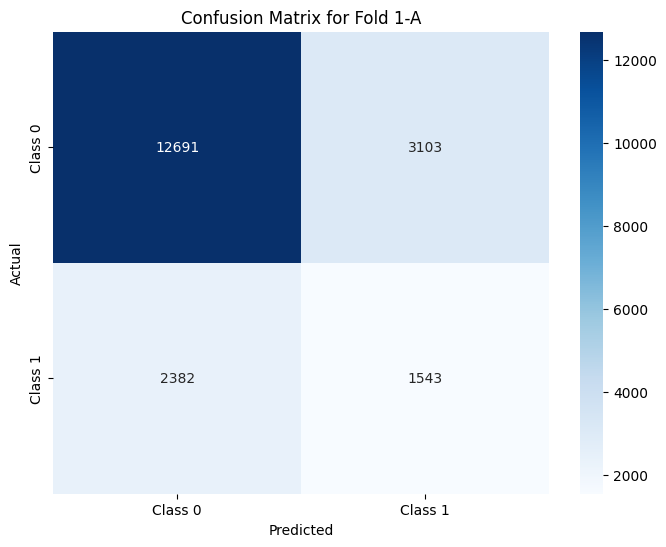

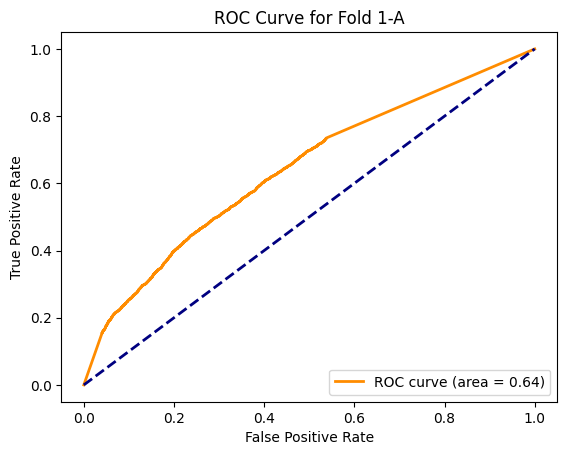

In [31]:
evaluate_model(best_model_knn_kermit, feature_df, train_cols, 'Kermit', results_knn_kermit, spec_fold= "best")

Fold 2-B Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.80      0.59      8789
           1       0.56      0.22      0.32     10277

    accuracy                           0.49     19066
   macro avg       0.51      0.51      0.45     19066
weighted avg       0.52      0.49      0.44     19066



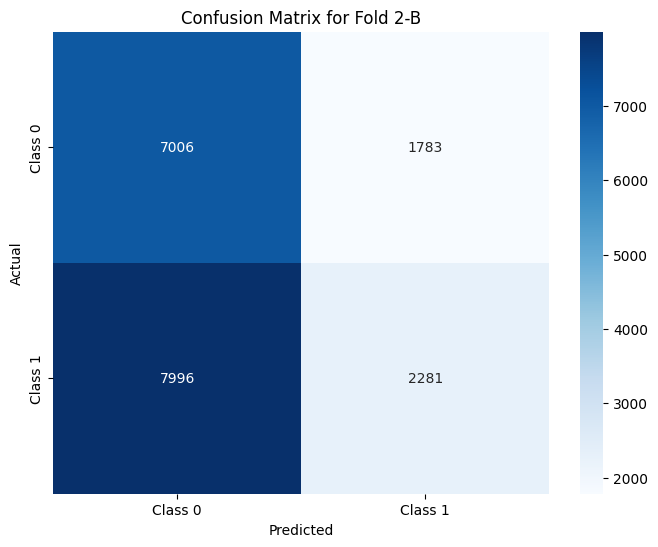

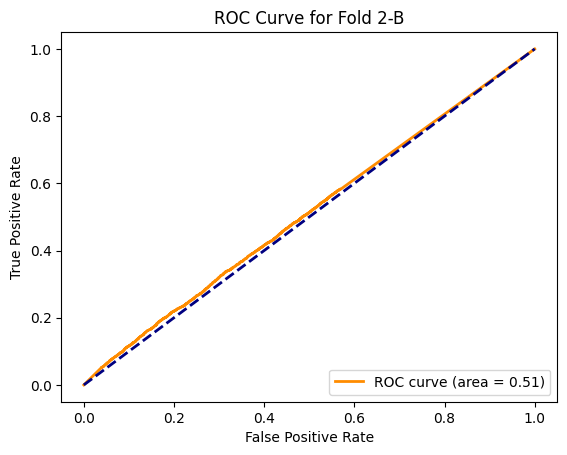

In [32]:
evaluate_model(best_model_knn_kermit, feature_df, train_cols, 'Kermit', results_knn_kermit, spec_fold="worst")

#### Waldorf & Statler

In [33]:
results_knn_ws

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.945628,0.098592,0.006897,0.012891,0.534153
1,0-B,0.974321,0.176471,0.060150,0.089720,0.588922
2,1-A,0.968051,0.206667,0.057196,0.089595,0.583496
3,1-B,0.978459,0.128655,0.078014,0.097130,0.610869
4,2-A,0.987032,0.064516,0.035088,0.045455,0.570656
5,2-B,0.976083,0.126263,0.081169,0.098814,0.596317


Fold 1-B Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18705
           1       0.13      0.08      0.10       282

    accuracy                           0.98     18987
   macro avg       0.56      0.54      0.54     18987
weighted avg       0.97      0.98      0.98     18987



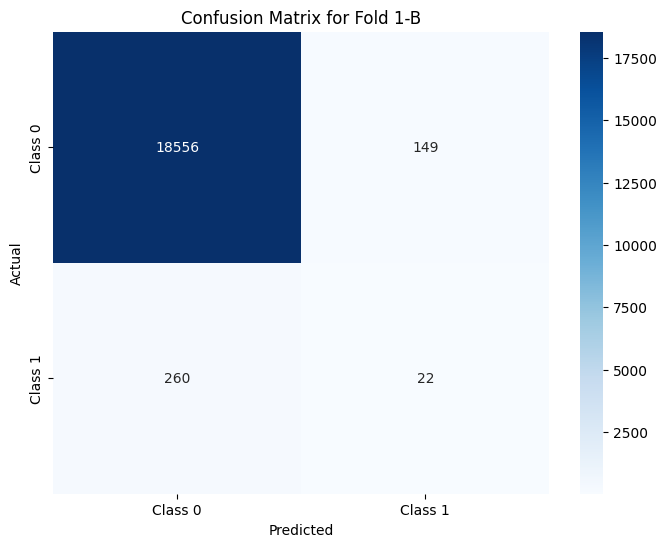

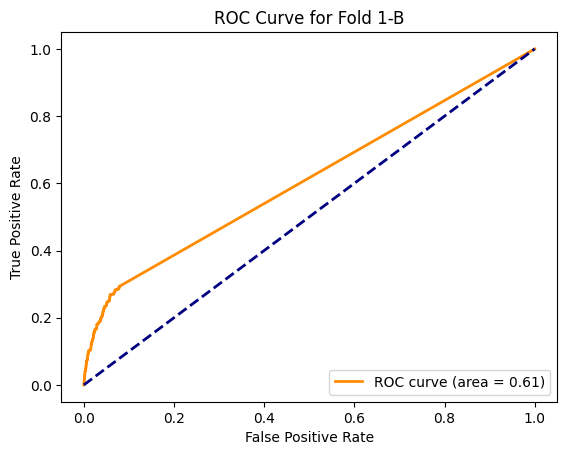

In [34]:
evaluate_model(best_models_knn_ws, feature_df, train_cols, 'Audio_StatlerWaldorf', results_knn_ws, spec_fold= "best")

Fold 0-A Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     18701
           1       0.10      0.01      0.01      1015

    accuracy                           0.95     19716
   macro avg       0.52      0.50      0.49     19716
weighted avg       0.90      0.95      0.92     19716



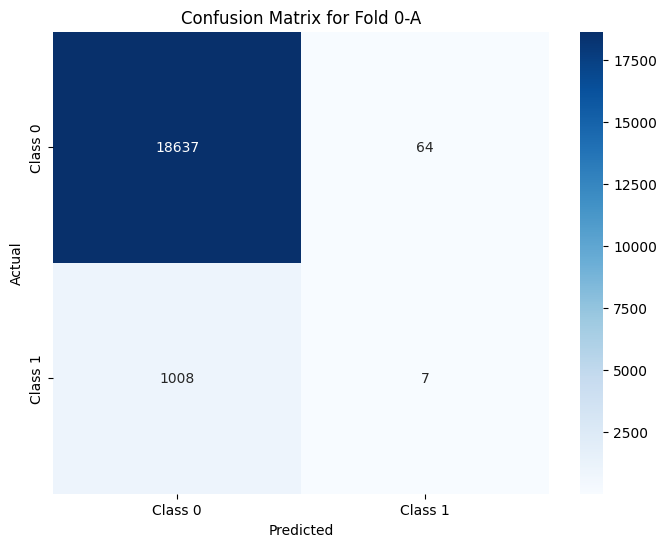

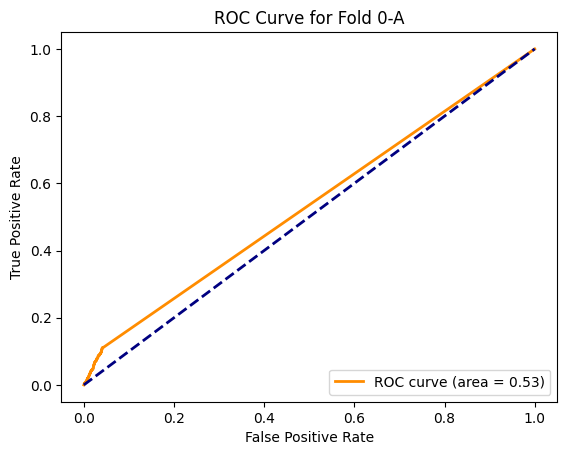

In [35]:
evaluate_model(best_models_knn_ws, feature_df, train_cols, 'Audio_StatlerWaldorf', results_knn_ws, spec_fold= "worst")

### Logistic Regression

In [36]:
# load if necessary

import pickle
import pandas as pd

# Load Statler results
with open('../model_vars/sim1_audio/ws_lr_results.pkl', 'rb') as f:
    ws_data = pickle.load(f)
    results_lr_ws = ws_data['results_ws']
    summary_lr_ws = ws_data['summary_ws']
    best_models_lr_ws = ws_data['best_models_ws']



# Load Kermit results
with open('../model_vars/sim1_audio/kermit_lr_results.pkl', 'rb') as f:
    kermit_data = pickle.load(f)
    results_lr_kermit = kermit_data['results_kermit']
    summary_lr_kermit = kermit_data['summary_kermit']
    best_model_lr_kermit = kermit_data['best_model_kermit']


#### Kermit

In [37]:
results_lr_kermit

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.849970,0.443850,0.056927,0.100912,0.688805
1,0-B,0.863485,0.405405,0.047375,0.084836,0.736876
2,1-A,0.571074,0.281374,0.743185,0.408200,0.687878
3,1-B,0.585085,0.760743,0.078660,0.142577,0.721411
4,2-A,0.732812,0.511317,0.168419,0.253379,0.642558
5,2-B,0.457621,0.474235,0.057312,0.102266,0.442516


Fold 0-B Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     16432
           1       0.41      0.05      0.08      2533

    accuracy                           0.86     18965
   macro avg       0.64      0.52      0.51     18965
weighted avg       0.81      0.86      0.81     18965



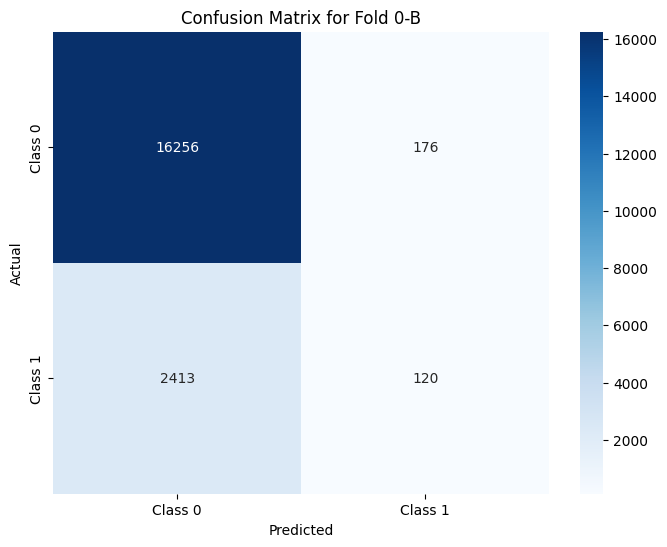

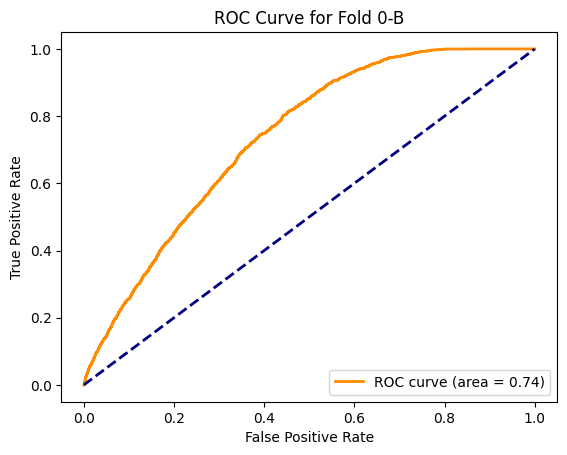

In [38]:
evaluate_model(best_model_lr_kermit, feature_df, train_cols, 'Kermit', results_lr_kermit, spec_fold= "best")

Fold 2-B Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.93      0.61      8789
           1       0.47      0.06      0.10     10277

    accuracy                           0.46     19066
   macro avg       0.47      0.49      0.36     19066
weighted avg       0.47      0.46      0.34     19066



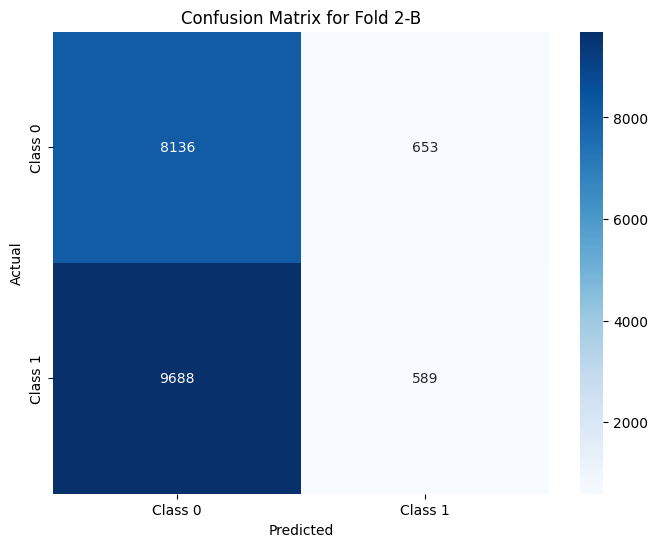

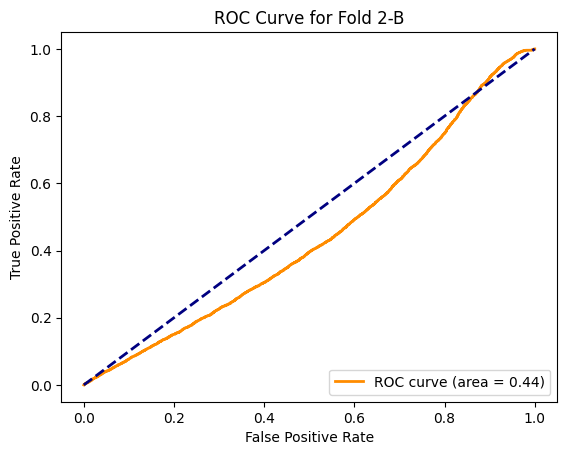

In [39]:
evaluate_model(best_model_lr_kermit, feature_df, train_cols, 'Kermit', results_lr_kermit, spec_fold= "worst")

#### Waldorf & Statler

In [40]:
results_lr_ws

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.948519,NaN,0.0,0.0,0.694428
1,0-B,0.978961,NaN,0.0,0.0,0.649538
2,1-A,0.972514,NaN,0.0,0.0,0.681075
3,1-B,0.985148,NaN,0.0,0.0,0.741059
4,2-A,0.991200,NaN,0.0,0.0,0.694865
5,2-B,0.983846,NaN,0.0,0.0,0.686651


Fold 1-B Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18705
           1       0.00      0.00      0.00       282

    accuracy                           0.99     18987
   macro avg       0.49      0.50      0.50     18987
weighted avg       0.97      0.99      0.98     18987



c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


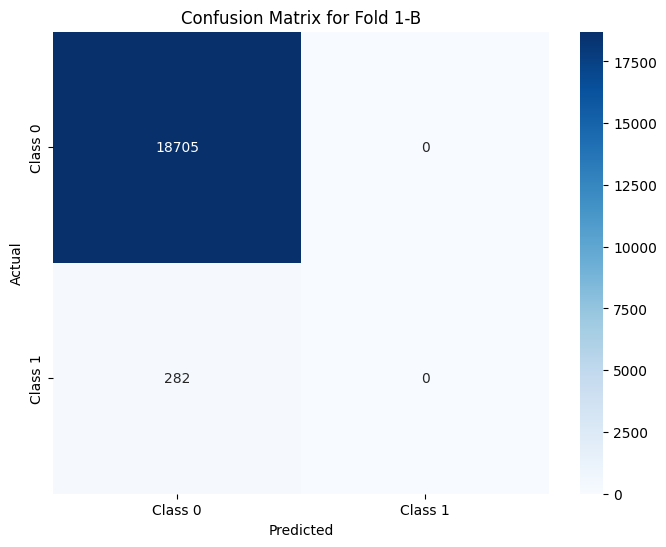

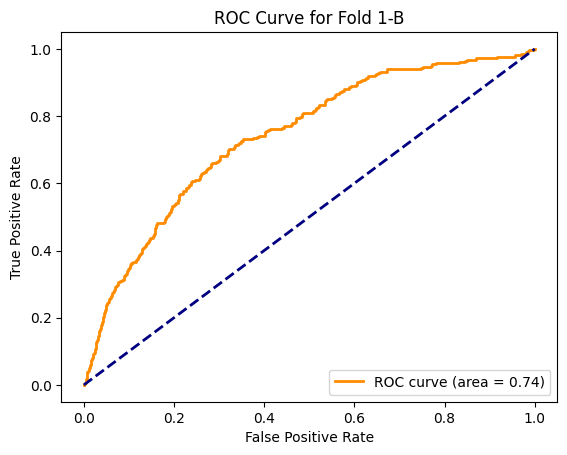

In [41]:
evaluate_model(best_models_lr_ws, feature_df, train_cols, target_col= 'Audio_StatlerWaldorf', cv_results = results_lr_ws, spec_fold= "best")

Fold 0-B Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18566
           1       0.00      0.00      0.00       399

    accuracy                           0.98     18965
   macro avg       0.49      0.50      0.49     18965
weighted avg       0.96      0.98      0.97     18965



c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


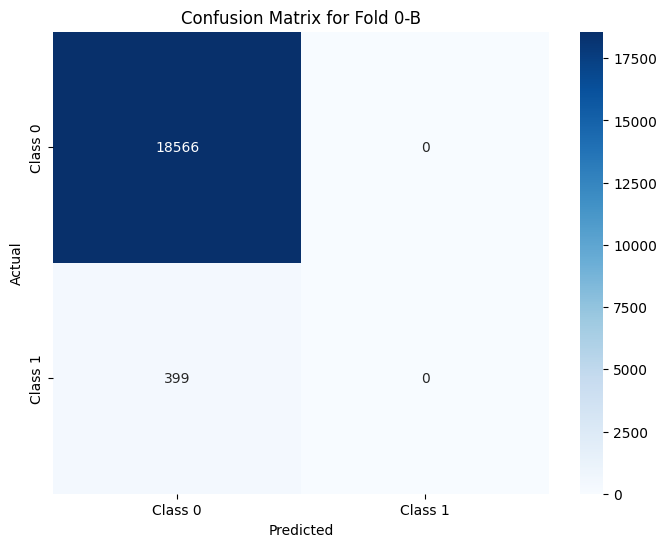

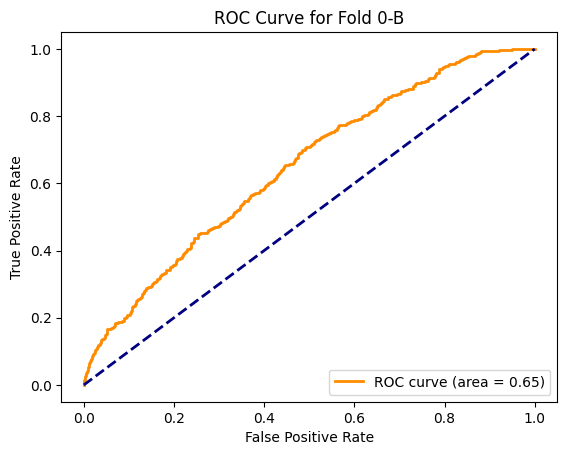

In [42]:
evaluate_model(best_models_lr_ws, feature_df, train_cols, 'Audio_StatlerWaldorf', results_lr_ws, spec_fold= "worst")

### XGBoost

In [43]:
# load if necessary
import pickle
import pandas as pd

# Load Statler results
with open('../model_vars/sim1_audio/ws_xgb_results.pkl', 'rb') as f:
    ws_data = pickle.load(f)
    results_xgb_ws = ws_data['results_ws']
    summary_xgb_ws = ws_data['summary_ws']
    best_models_xgb_ws = ws_data['best_model_ws']

# Load Kermit results
with open('../model_vars/sim1_audio/kermit_xgb_results.pkl', 'rb') as f:
    kermit_data = pickle.load(f)
    results_xgb_kermit = kermit_data['results_kermit']
    summary_xgb_kermit = kermit_data['summary_kermit']
    best_model_xgb_kermit = kermit_data['best_model_kermit']

#### Kermit

In [44]:
results_xgb_kermit

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.836579,0.413265,0.250000,0.311538,0.699812
1,0-B,0.850461,0.375514,0.180418,0.243733,0.747752
2,1-A,0.811704,0.603113,0.157962,0.250353,0.694307
3,1-B,0.616948,0.806395,0.166567,0.276102,0.697020
4,2-A,0.715418,0.455146,0.290002,0.354274,0.649832
5,2-B,0.460820,0.499081,0.079303,0.136860,0.467203


Fold 0-B Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92     16432
           1       0.38      0.18      0.24      2533

    accuracy                           0.85     18965
   macro avg       0.63      0.57      0.58     18965
weighted avg       0.82      0.85      0.83     18965



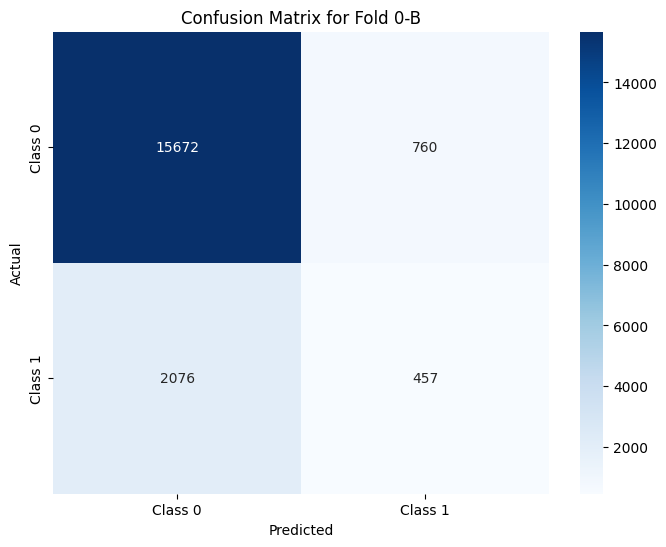

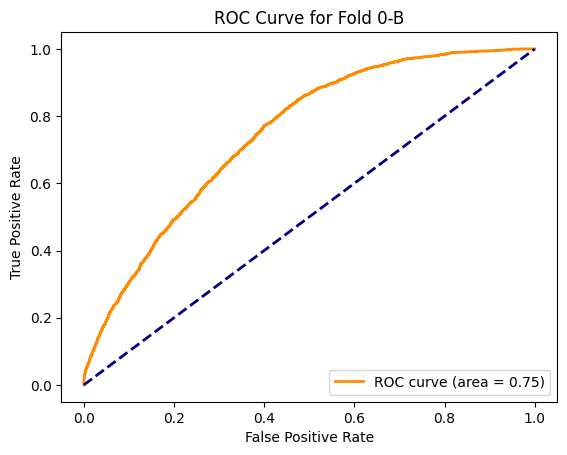

In [45]:
evaluate_model(best_model_xgb_kermit, feature_df, train_cols, 'Kermit', results_xgb_kermit, spec_fold= "best")

Fold 2-B Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.91      0.61      8789
           1       0.50      0.08      0.14     10277

    accuracy                           0.46     19066
   macro avg       0.48      0.49      0.37     19066
weighted avg       0.48      0.46      0.35     19066



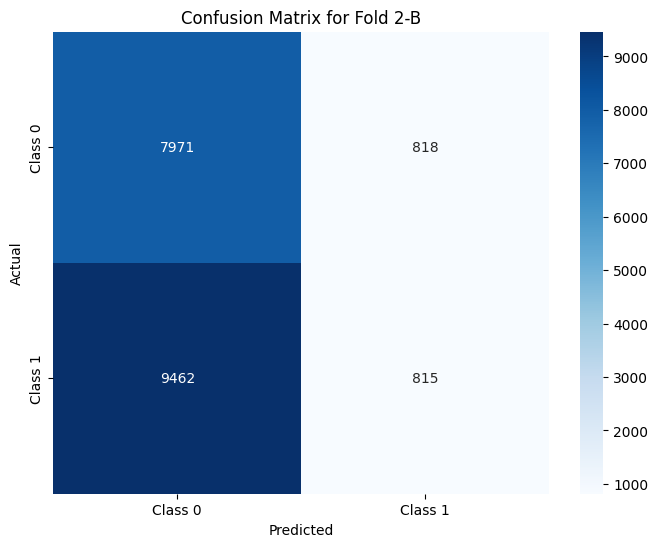

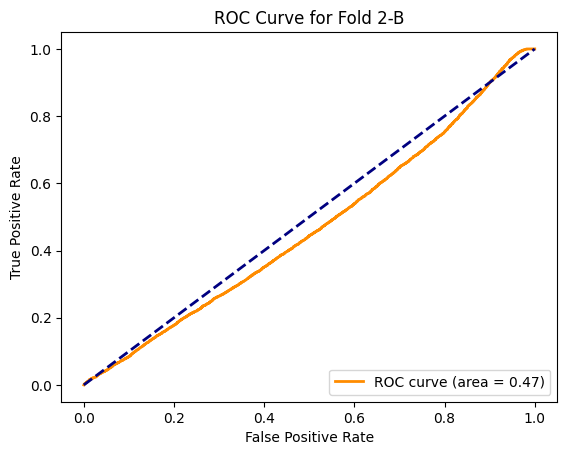

In [46]:

# Evaluate 
evaluate_model(best_model_xgb_kermit, feature_df, train_cols, 'Kermit',  results_xgb_kermit, spec_fold= "worst")

#### Waldorf & Statler

In [47]:
results_xgb_ws

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.948570,0.60000,0.002956,0.005882,0.722305
1,0-B,0.979225,0.60000,0.037594,0.070755,0.720725
2,1-A,0.972514,NaN,0.000000,0.000000,0.728758
3,1-B,0.984990,0.20000,0.003546,0.006969,0.744794
4,2-A,0.991200,0.50000,0.005848,0.011561,0.781613
5,2-B,0.983269,0.26087,0.019481,0.036254,0.777999


Fold 2-A Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19261
           1       0.50      0.01      0.01       171

    accuracy                           0.99     19432
   macro avg       0.75      0.50      0.50     19432
weighted avg       0.99      0.99      0.99     19432



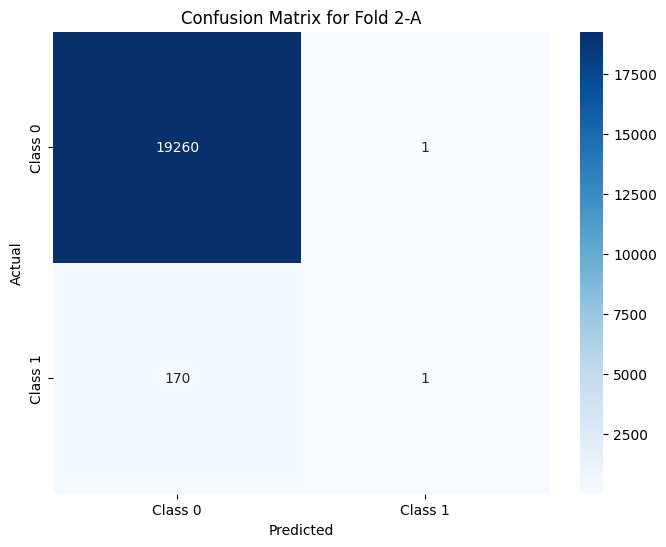

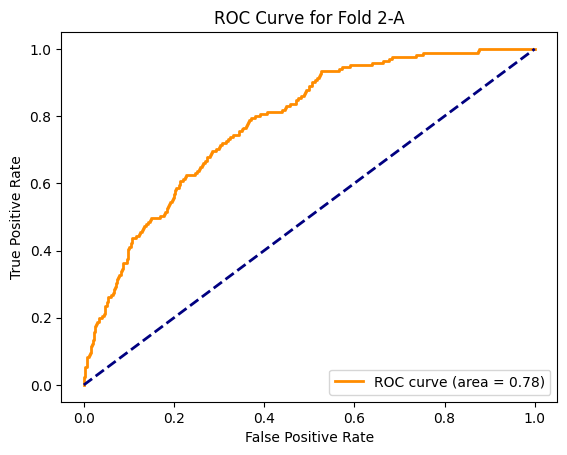

In [48]:
evaluate_model(best_models_xgb_ws, feature_df, train_cols, 'Audio_StatlerWaldorf',  results_xgb_ws, spec_fold= "best")

Fold 0-B Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18566
           1       0.60      0.04      0.07       399

    accuracy                           0.98     18965
   macro avg       0.79      0.52      0.53     18965
weighted avg       0.97      0.98      0.97     18965



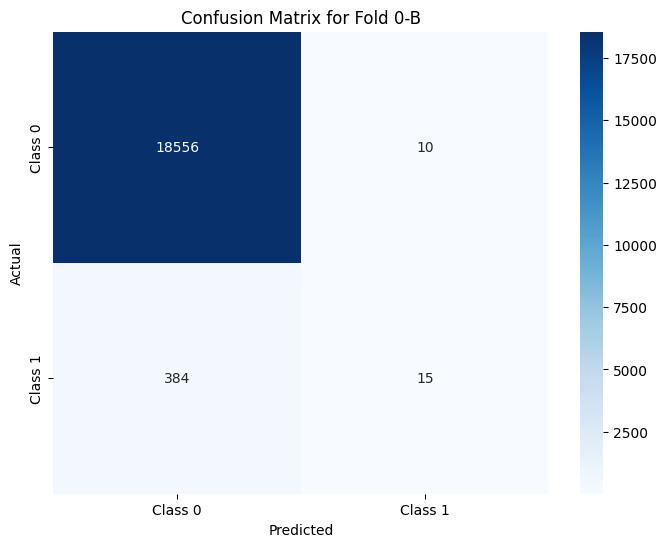

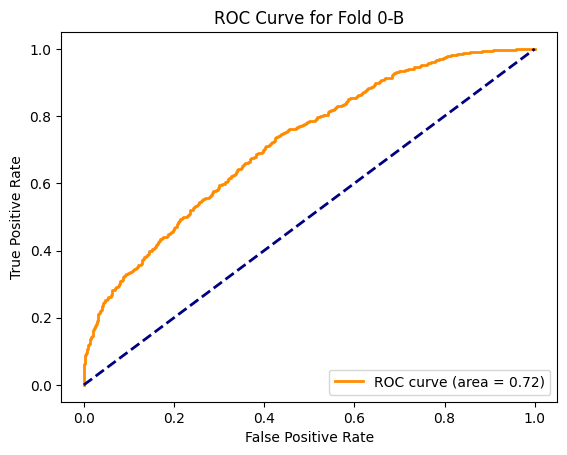

In [49]:
evaluate_model(best_models_xgb_ws, feature_df, train_cols, 'Audio_StatlerWaldorf', results_xgb_ws, spec_fold= "worst")

### Feature Importance

<Figure size 1200x800 with 0 Axes>

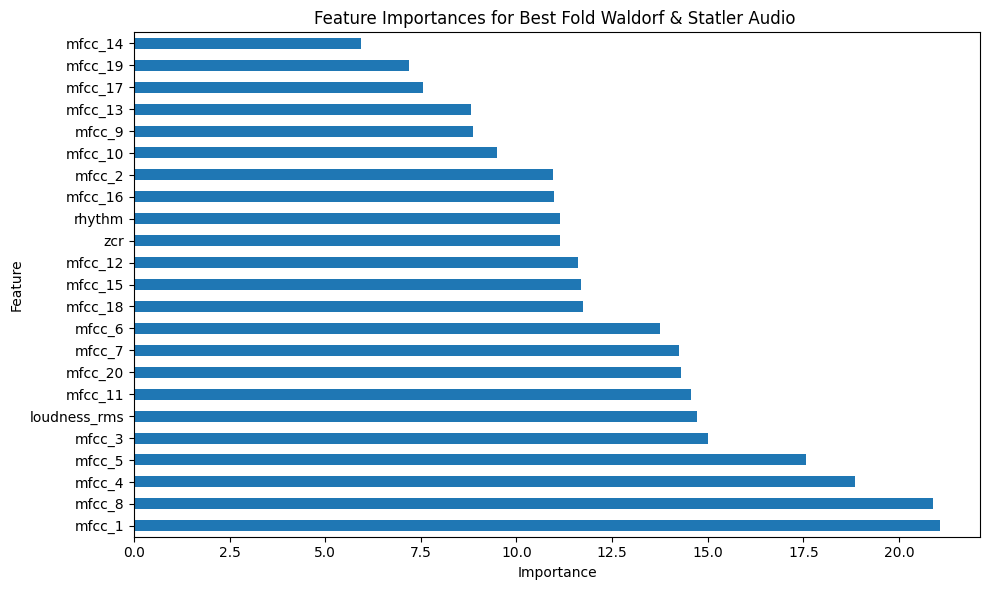

In [50]:
from scripts.nested_cv import plot_feature_importances 
plot_feature_importances(best_models_xgb_ws, feature_df, train_cols, results_xgb_ws, name= "Waldorf & Statler Audio ")

<Figure size 1200x800 with 0 Axes>

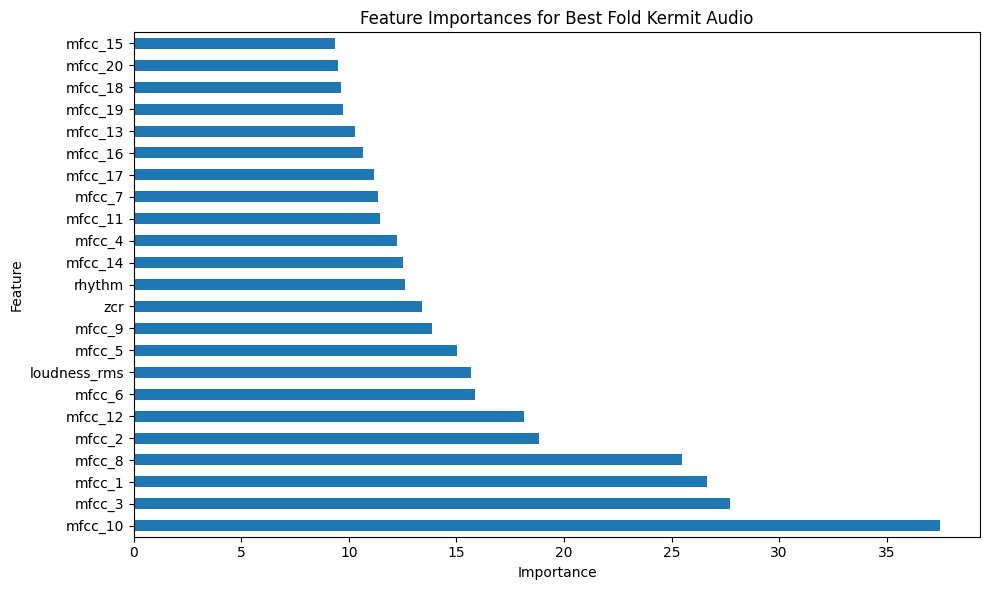

In [51]:
plot_feature_importances(best_model_xgb_kermit, feature_df, train_cols, results_xgb_kermit, name= "Kermit Audio")

## Conclusion

For the detection of Kermit, XGBoost consistently outperformed both KNN and Logistic Regression in terms of accuracy and ROC AUC, particularly in the best-performing folds. Logistic Regression and KNN both struggled with class imbalance and variability across folds, highlighting their limited robustness in handling diverse data distributions. Among all models, fold 2-B emerged as the worst-performing fold, likely due to Kermit being dressed as Robin Hood in that part of the episode. 
For the best-performing folds, KNN achieved its highest AUC on fold 1-A, while Logistic Regression and XGBoost both performed best on fold 0-B.
An analysis of the feature importances for the best-performing XGBoost fold underscores the positive impact of including MFCC (Mel-Frequency Cepstral Coefficients) features in the model. Among the top 10 most important features, only Loudness from the original feature set was included, further emphasizing the value of engineered features in enhancing classification performance.

| Audio Results Kermit      | Accuracy   | Precision  | Recall     | F1        | ROC AUC   |
|---------------------------|------------|------------|------------|-----------|-----------|
| **KNN - Overall**         | 0.6551     | 0.3835     | 0.3413     | 0.3358    | 0.5992    |
| **Logistic - Overall**    | 0.6767     | 0.4795     | 0.1919     | 0.1820    | 0.6533    |
| **XGBoost - Overall**     | 0.7153     | 0.5254     | 0.1874     | 0.2621    | 0.6593    |
| **KNN - Best Fold**       | 0.7218     | 0.3321     | 0.3931     | 0.3601    | 0.6413    |
| **Logistic - Best Fold**  | 0.8635     | 0.4054     | 0.0474     | 0.0848    | 0.7369    |
| **XGBoost - Best Fold**   | 0.8505     | 0.3755     | 0.1804     | 0.2437    | 0.7478    |


For Waldorf and Statler, XGBoost consistently outperformed both KNN and Logistic Regression in terms of accuracy and ROC AUC, particularly in the best-performing folds. However, all models struggled significantly with the extreme class imbalance, leading to poor recall for the minority class. This issue was even more pronounced than in the Kermit detection task. Across all three models, fold 0-A emerged as the worst-performing fold, likely because it contained the highest number of occurrences of Waldorf and Statler, further exacerbating the imbalance in the training data.
The class imbalance heavily skewed performance metrics toward the negative class (absence of Waldorf and Statler). The high accuracy values observed across all models primarily reflect their tendency to predict the majority class, which dominates the dataset. While fold 1-B showed the best AUC performance for KNN and Logistic Regression, the overall performance of Logistic Regression remained particularly poor, as it consistently defaulted to predicting the majority class for all folds. For XGBoost, fold 2-A achieved the highest AUC, but based on precision and recall metrics, fold 0-B would be the true best fold. Although fold 0-B had the lowest AUC, it performed comparably to other folds in the overall context, making it the most balanced fold in terms of recall and precision.
Similar to the Kermit detection task, the feature importance analysis for the best-performing XGBoost fold underscores the significance of the MFCC features, reaffirming their critical role in improving model performance. Interestingly, loudness remains one of the few features from the original feature set to make it into the top 10 most important features, further emphasizing its value.



| Audio Results W&S         | Accuracy   | Precision  | Recall     | F1        | ROC AUC   |
|---------------------------|------------|------------|------------|-----------|-----------|
| **KNN - Overall**         | 0.9716     | 0.1335     | 0.0531     | 0.0723    | 0.5807    |
| **Logistic - Overall**    | 0.9767     | 0.0000*    | 0.0000*    | 0.0000*   | 0.6913    |
| **XGBoost - Overall**     | 0.9766     | 0.3601     | 0.0116     | 0.0219    | 0.7460    |
| **KNN - Best Fold**       | 0.9785     | 0.9734     | 0.9785     | 0.9759    | 0.6109    |
| **Logistic - Best Fold**  | 0.9851     | 0.0000*    | 0.0000*    | 0.0000*   | 0.7411    |
| **Logistic -  Fold with highest Recall**  | 0.9792    | 0.6000    | 0.0376   | 0.07076   | 0.7207   |
| **XGBoost - Best Fold**   | 0.9912     | 0.5000     | 0.0058     | 0.0116    | 0.7816    |

\* Logistic Regression performs the worst as it cannot handle the class imbalance and always predicts the majority class.
